<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Natural%20Language%20Processing/Natural%20Language%20Processing%20101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import tensorflow as tf
import pathlib
import os
import shutil
import re
import math
import string

## Download the data

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
path = tf.keras.utils.get_file(origin=url, untar=True)

In [3]:
data_dir = pathlib.Path(path).parent
for i in data_dir.iterdir():
  print(i)

/root/.keras/datasets/aclImdb_v1.tar.gz
/root/.keras/datasets/aclImdb


In [4]:
aclImdb = data_dir/'aclImdb'
for i in aclImdb.iterdir():
  print(i)

/root/.keras/datasets/aclImdb/README
/root/.keras/datasets/aclImdb/test
/root/.keras/datasets/aclImdb/train
/root/.keras/datasets/aclImdb/imdb.vocab
/root/.keras/datasets/aclImdb/imdbEr.txt


In [5]:
train_dir = aclImdb/'train'
test_dir = aclImdb/'test'

In [6]:
for i in train_dir.iterdir():
  print(i,'-'*10,'Is this a directory ?',i.is_dir())

/root/.keras/datasets/aclImdb/train/urls_pos.txt ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/train/labeledBow.feat ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/train/unsup ---------- Is this a directory ? True
/root/.keras/datasets/aclImdb/train/urls_unsup.txt ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/train/urls_neg.txt ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/train/neg ---------- Is this a directory ? True
/root/.keras/datasets/aclImdb/train/pos ---------- Is this a directory ? True
/root/.keras/datasets/aclImdb/train/unsupBow.feat ---------- Is this a directory ? False


In [7]:
for i in test_dir.iterdir():
    print(i,'-'*10,'Is this a directory ?',i.is_dir())

/root/.keras/datasets/aclImdb/test/urls_pos.txt ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/test/labeledBow.feat ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/test/urls_neg.txt ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/test/neg ---------- Is this a directory ? True
/root/.keras/datasets/aclImdb/test/pos ---------- Is this a directory ? True


In [8]:
dir_to_remove = '/root/.keras/datasets/aclImdb/train/unsup'
shutil.rmtree(dir_to_remove)
for i in train_dir.iterdir():
  print(i,'-'*10,'Is this a directory ?',i.is_dir())

/root/.keras/datasets/aclImdb/train/urls_pos.txt ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/train/labeledBow.feat ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/train/urls_unsup.txt ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/train/urls_neg.txt ---------- Is this a directory ? False
/root/.keras/datasets/aclImdb/train/neg ---------- Is this a directory ? True
/root/.keras/datasets/aclImdb/train/pos ---------- Is this a directory ? True
/root/.keras/datasets/aclImdb/train/unsupBow.feat ---------- Is this a directory ? False


### Load the data

In [9]:
batch_size = 1024
seed = 123

In [10]:
raw_train = tf.keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, seed=seed, validation_split=0.2, subset='training')
raw_val = tf.keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, seed=seed, validation_split=0.2, subset='validation')
raw_test = tf.keras.utils.text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Preprocessing

Look at some example and determine what preprocessing needs to be done

In [11]:
text_batch, label_batch = next(iter(raw_train))

for text in text_batch.numpy()[:1]:
  print(text)

b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"


In [12]:
# we have to remove the <br />, quotations punctuations etc.. 

def custom_standardization(text):
  # lowercase
  lower = tf.strings.lower(text)
  # remove <br />
  strip_html = tf.strings.regex_replace(lower, "<[^>]+>", " ")
  # remove punctuations
  return tf.strings.regex_replace(strip_html,''.format(string.punctuation),'')

In [13]:
# let's see the output of preprocessing
custom_standardization(text)

<tf.Tensor: shape=(), dtype=string, numpy=b"oh my god! please, for the love of all that is holy, do not watch this movie! it it 82 minutes of my life i will never get back. sure, i could have stopped watching half way through. but i thought it might get better. it didn't. anyone who actually enjoyed this movie is one seriously sick and twisted individual. no wonder us australians/new zealanders have a terrible reputation when it comes to making movies. everything about this movie is horrible, from the acting to the editing. i don't even normally write reviews on here, but in this case i'll make an exception. i only wish someone had of warned me before i hired this catastrophe">

In [14]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

In [15]:
text_vectorize = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                                   standardize=custom_standardization, 
                                                   output_sequence_length=sequence_length)


In [20]:
binary_vectorize = tf.keras.layers.TextVectorization(max_tokens=vocab_size, 
                                                     output_mode='multi_hot')

In [21]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_only = raw_train.map(lambda text, label: text, num_parallel_calls=tf.data.AUTOTUNE)

text_vectorize.adapt(text_only)
binary_vectorize.adapt(text_only)

### Apply preprocessing

In [22]:
def vectorizer(text,label):
  text = tf.expand_dims(text,axis=-1)
  text = text_vectorize(text)
  return text, label

def binary_vectorizer(text,label):
  text = tf.expand_dims(text,axis=-1)
  text = binary_vectorize(text)
  return text, label

In [25]:
train_ds = raw_train.map(vectorizer).cache().prefetch(tf.data.AUTOTUNE)
val_ds = raw_val.map(vectorizer).cache().prefetch(tf.data.AUTOTUNE)
test_ds = raw_test.map(vectorizer).cache().prefetch(tf.data.AUTOTUNE)

In [26]:
# MULTI HOT OUTPUT 
train_ds_binary = raw_train.map(binary_vectorizer).cache().prefetch(tf.data.AUTOTUNE)
val_ds_binary = raw_val.map(binary_vectorizer).cache().prefetch(tf.data.AUTOTUNE)
test_ds_binary = raw_test.map(binary_vectorizer).cache().prefetch(tf.data.AUTOTUNE)

## Model building 


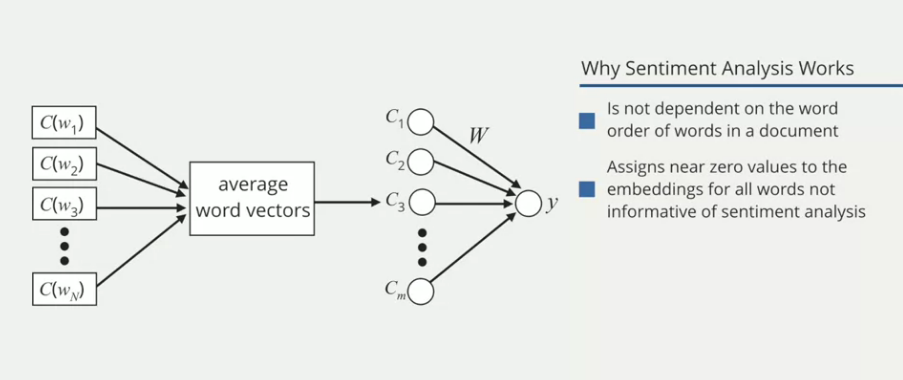


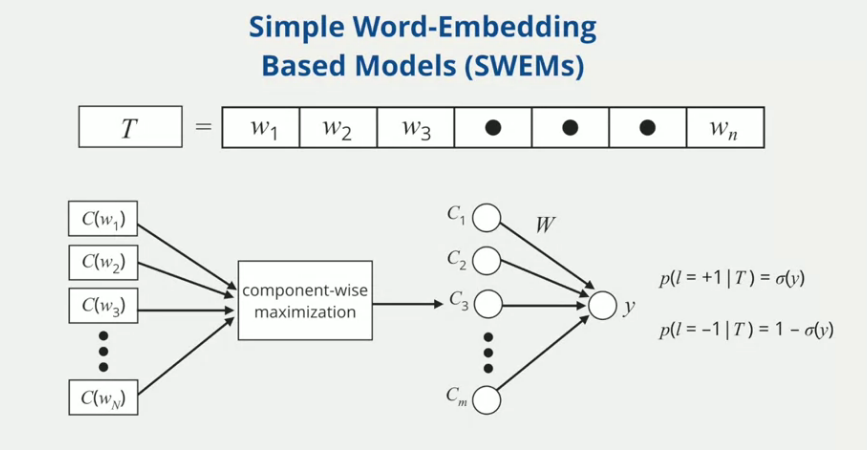






## Multi Layer Perceptron - (MLP)

In [38]:
embedding_dim=16

model_1 = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim),
                               tf.keras.layers.GlobalAvgPool1D(),
                               tf.keras.layers.Dense(16,'relu'),
                               tf.keras.layers.Dense(1)
])

model_1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['binary_accuracy'])

def decay_lr(epoch):
  return 0.01*math.pow(0.6,epoch)

lr = tf.keras.callbacks.LearningRateScheduler(decay_lr)
es = tf.keras.callbacks.EarlyStopping()
model_1_history = model_1.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[es, lr])

Epoch 1/10
20/20 [==============================] - 1s 16ms/step - loss: 0.6663 - binary_accuracy: 0.5106 - val_loss: 0.5988 - val_binary_accuracy: 0.6178 - lr: 0.0100
Epoch 2/10
20/20 [==============================] - 0s 11ms/step - loss: 0.5295 - binary_accuracy: 0.7108 - val_loss: 0.4809 - val_binary_accuracy: 0.7538 - lr: 0.0060


Evaluation

In [39]:
loss, acc = model_1.evaluate(test_ds)
print(f'Model accuracy :{acc} Loss :{loss}')

25/25 [==============================] - 0s 4ms/step - loss: 0.4939 - binary_accuracy: 0.7474
Model accuracy :0.7473599910736084 Loss :0.493875116109848


## Logistic regression : Continuous Bag of Words Model 

In [50]:
embedding_dim=16

model_2 = tf.keras.Sequential([
                               tf.keras.layers.Dense(1)
])

model_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['binary_accuracy'])

def decay_lr(epoch):
  return 0.01*math.pow(0.6,epoch)
lr = tf.keras.callbacks.LearningRateScheduler(decay_lr)
es = tf.keras.callbacks.EarlyStopping()
model_2_history = model_2.fit(train_ds_binary, epochs=10, validation_data=val_ds_binary,  callbacks=[es,lr])

Epoch 1/10
20/20 [==============================] - 1s 16ms/step - loss: 0.4821 - binary_accuracy: 0.7277 - val_loss: 0.3568 - val_binary_accuracy: 0.8524 - lr: 0.0100
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.2950 - binary_accuracy: 0.8848 - val_loss: 0.3151 - val_binary_accuracy: 0.8674 - lr: 0.0060


Evaluation

In [51]:
loss, acc = model_2.evaluate(test_ds_binary)
print(f'Model accuracy :{acc} Loss :{loss}')

25/25 [==============================] - 0s 7ms/step - loss: 0.3332 - binary_accuracy: 0.8568
Model accuracy :0.8567600250244141 Loss :0.33315733075141907


## Gated recurrent unit : GRU

In [83]:
embedding_dim=32

model_3 = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
                               tf.keras.layers.GRU(32),
                               tf.keras.layers.Dense(16,'relu'),
                               tf.keras.layers.Dense(1)
])

model_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

model_3_history = model_3.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
20/20 [==============================] - 11s 399ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6926 - val_accuracy: 0.4886
Epoch 2/5
20/20 [==============================] - 7s 350ms/step - loss: 0.6884 - accuracy: 0.5028 - val_loss: 0.6867 - val_accuracy: 0.4886
Epoch 3/5
20/20 [==============================] - 7s 342ms/step - loss: 0.6586 - accuracy: 0.5166 - val_loss: 0.6422 - val_accuracy: 0.6112
Epoch 4/5
20/20 [==============================] - 7s 346ms/step - loss: 0.5007 - accuracy: 0.7480 - val_loss: 0.4628 - val_accuracy: 0.7810
Epoch 5/5
20/20 [==============================] - 7s 338ms/step - loss: 0.3471 - accuracy: 0.8503 - val_loss: 0.4322 - val_accuracy: 0.8024


Evaluation

In [84]:
loss, acc = model_3.evaluate(test_ds)
print(f'Model accuracy :{acc} Loss :{loss}')

25/25 [==============================] - 3s 112ms/step - loss: 0.4517 - accuracy: 0.7889
Model accuracy :0.7888799905776978 Loss :0.4517124891281128


## Long short-term memory : LSTM

In [73]:
embedding_dim=32

model_4 = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
                               tf.keras.layers.LSTM(32),
                               tf.keras.layers.Dense(16,'relu'),
                               tf.keras.layers.Dense(1)
])

model_4.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

model_4_history = model_4.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
20/20 [==============================] - 13s 475ms/step - loss: 0.6929 - accuracy: 0.5028 - val_loss: 0.6923 - val_accuracy: 0.4886
Epoch 2/5
20/20 [==============================] - 8s 421ms/step - loss: 0.6795 - accuracy: 0.5028 - val_loss: 0.6177 - val_accuracy: 0.4890
Epoch 3/5
20/20 [==============================] - 8s 421ms/step - loss: 0.5483 - accuracy: 0.7072 - val_loss: 0.4882 - val_accuracy: 0.7718
Epoch 4/5
20/20 [==============================] - 8s 422ms/step - loss: 0.3956 - accuracy: 0.8306 - val_loss: 0.4226 - val_accuracy: 0.8024
Epoch 5/5
20/20 [==============================] - 9s 440ms/step - loss: 0.3050 - accuracy: 0.8802 - val_loss: 0.4906 - val_accuracy: 0.8108


Evaluation

In [74]:
loss, acc = model_4.evaluate(test_ds)
print(f'Model accuracy :{acc} Loss :{loss}')

25/25 [==============================] - 3s 134ms/step - loss: 0.5331 - accuracy: 0.7932
Model accuracy :0.7932000160217285 Loss :0.5331316590309143


## Bidirectional LSTM

In [75]:
embedding_dim=32

model_5 = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                               tf.keras.layers.Dense(16,'relu'),
                               tf.keras.layers.Dense(1)
])

model_5.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

model_5_history = model_5.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
20/20 [==============================] - 17s 523ms/step - loss: 0.6925 - accuracy: 0.5028 - val_loss: 0.6905 - val_accuracy: 0.4886
Epoch 2/5
20/20 [==============================] - 8s 412ms/step - loss: 0.6833 - accuracy: 0.5028 - val_loss: 0.6722 - val_accuracy: 0.4886
Epoch 3/5
20/20 [==============================] - 8s 415ms/step - loss: 0.6140 - accuracy: 0.5991 - val_loss: 0.5224 - val_accuracy: 0.7394
Epoch 4/5
20/20 [==============================] - 8s 411ms/step - loss: 0.4499 - accuracy: 0.7979 - val_loss: 0.4504 - val_accuracy: 0.7804
Epoch 5/5
20/20 [==============================] - 8s 406ms/step - loss: 0.3489 - accuracy: 0.8549 - val_loss: 0.4127 - val_accuracy: 0.8074


Evaluation

In [76]:
loss, acc = model_5.evaluate(test_ds)
print(f'Model accuracy :{acc} Loss :{loss}')

25/25 [==============================] - 3s 118ms/step - loss: 0.4391 - accuracy: 0.8004
Model accuracy :0.8004400134086609 Loss :0.4391469955444336


## Stack two or more LSTM layers

In [80]:
embedding_dim=32

model_6 = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                               tf.keras.layers.LSTM(16),
                               tf.keras.layers.Dense(1)
])

model_6.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

model_6_history = model_6.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
20/20 [==============================] - 35s 1s/step - loss: 0.6923 - accuracy: 0.5028 - val_loss: 0.6898 - val_accuracy: 0.4886
Epoch 2/5
20/20 [==============================] - 21s 1s/step - loss: 0.6477 - accuracy: 0.5501 - val_loss: 0.5699 - val_accuracy: 0.6942
Epoch 3/5
20/20 [==============================] - 21s 1s/step - loss: 0.4637 - accuracy: 0.7869 - val_loss: 0.4683 - val_accuracy: 0.7820
Epoch 4/5
20/20 [==============================] - 21s 1s/step - loss: 0.3332 - accuracy: 0.8708 - val_loss: 0.4553 - val_accuracy: 0.8004
Epoch 5/5
20/20 [==============================] - 21s 1s/step - loss: 0.2533 - accuracy: 0.9136 - val_loss: 0.4690 - val_accuracy: 0.8166


Evaluation

In [81]:
loss, acc = model_6.evaluate(test_ds)
print(f'Model accuracy :{acc} Loss :{loss}')

25/25 [==============================] - 9s 342ms/step - loss: 0.4983 - accuracy: 0.8024
Model accuracy :0.8023599982261658 Loss :0.49834445118904114
